In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
import torch
from torch import nn

In [3]:
data = pd.read_csv('train.csv')

data.replace(-1, np.nan, inplace=True)
period = pd.PeriodIndex(year=data["year"],month=data["month"],day=data["day"],hour=data["hour"],freq="H")
# period
data["date_time"] = period
data.set_index(["date_time"],inplace=True)


# Drop rows with missing data
data = data.iloc[24:].fillna(method = 'ffill')

data = data.join(pd.get_dummies(data.cbwd))
del data['cbwd']


data = data.drop(['No','year','month','day','hour'], axis=1)
data.head()

# data.shape[0]

C:\Users\User\AppData\Local\Temp\ipykernel_17040\2528647765.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.iloc[24:].fillna(method = 'ffill')


,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
date_time,,,,,,,,,,,
2010-01-02 00:00,129.0,-16.0,-4.0,1020.0,1.79,0,0,False,False,True,False
2010-01-02 01:00,148.0,-15.0,-4.0,1020.0,2.68,0,0,False,False,True,False
2010-01-02 02:00,159.0,-11.0,-5.0,1021.0,3.57,0,0,False,False,True,False
2010-01-02 03:00,181.0,-7.0,-5.0,1022.0,5.36,1,0,False,False,True,False
2010-01-02 04:00,138.0,-7.0,-5.0,1022.0,6.25,2,0,False,False,True,False


<Axes: xlabel='date_time'>

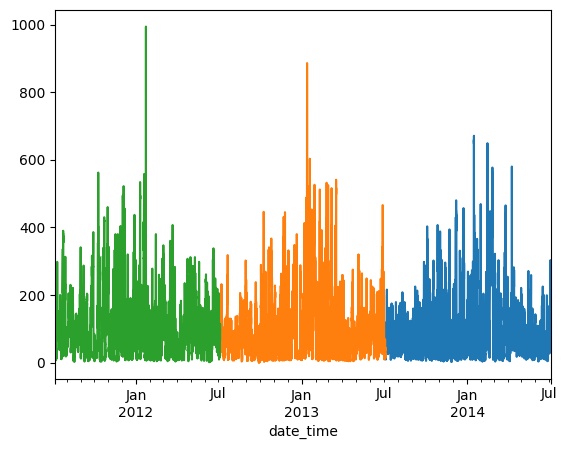

In [38]:
data['pm2.5'][-365*24:].plot()
data['pm2.5'][-365*24*2:-365*24].plot()
data['pm2.5'][-365*24*3:-365*24*2].plot()

In [4]:
scaler = MinMaxScaler()
norm_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
norm_data.head(169)

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
date_time,,,,,,,,,,,
2010-01-02 00:00,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.0,1.0,0.0
2010-01-02 01:00,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0
2010-01-02 02:00,0.159960,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0
2010-01-02 03:00,0.182093,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0
2010-01-02 04:00,0.138833,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2010-01-08 20:00,0.227364,0.338235,0.114754,0.636364,0.002290,0.000000,0.0,0.0,0.0,0.0,1.0
2010-01-08 21:00,0.226358,0.323529,0.081967,0.654545,0.002290,0.000000,0.0,0.0,1.0,0.0,0.0
2010-01-08 22:00,0.169014,0.352941,0.163934,0.654545,0.007639,0.000000,0.0,0.0,1.0,0.0,0.0


In [86]:
n = 7 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])

In [87]:
print(X[0])
print(Y[0])

[[0.35294118 0.24590164 0.52727273 ... 0.         1.         0.        ]
 [0.36764706 0.24590164 0.52727273 ... 0.         1.         0.        ]
 [0.42647059 0.2295082  0.54545455 ... 0.         1.         0.        ]
 ...
 [0.32352941 0.08196721 0.65454545 ... 1.         0.         0.        ]
 [0.35294118 0.16393443 0.65454545 ... 1.         0.         0.        ]
 [0.35294118 0.13114754 0.65454545 ... 1.         0.         0.        ]]
0.1659959758551308


In [88]:
X= np.array(X)
Y= np.array(Y)
print(X.shape)
print(Y.shape)

(39312, 168, 10)
(39312,)


In [89]:
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

In [90]:
print(train_x[0])
print(train_y[0])

[[0.35294118 0.24590164 0.52727273 ... 0.         1.         0.        ]
 [0.36764706 0.24590164 0.52727273 ... 0.         1.         0.        ]
 [0.42647059 0.2295082  0.54545455 ... 0.         1.         0.        ]
 ...
 [0.32352941 0.08196721 0.65454545 ... 1.         0.         0.        ]
 [0.35294118 0.16393443 0.65454545 ... 1.         0.         0.        ]
 [0.35294118 0.13114754 0.65454545 ... 1.         0.         0.        ]]
0.1659959758551308


In [91]:
print(train_x.shape)
print(train_y.shape)

(31449, 168, 10)
(31449,)


In [92]:
n_days = 7*24
n_features = 10

model = Sequential()
model.add(LSTM(32, input_shape=(n_days, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)

In [93]:
model.fit(train_x,train_y, batch_size=128,epochs=200, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])

Epoch 1/200
246/246 [==============================] - 33s 119ms/step - loss: 0.0513 - val_loss: 0.0474 - lr: 0.0010
Epoch 2/200
246/246 [==============================] - 57s 234ms/step - loss: 0.0455 - val_loss: 0.0466 - lr: 0.0010
Epoch 3/200
246/246 [==============================] - 69s 281ms/step - loss: 0.0437 - val_loss: 0.0435 - lr: 0.0010
Epoch 4/200
246/246 [==============================] - 91s 371ms/step - loss: 0.0422 - val_loss: 0.0456 - lr: 0.0010
Epoch 5/200
246/246 [==============================] - 92s 374ms/step - loss: 0.0410 - val_loss: 0.0434 - lr: 0.0010
Epoch 6/200
246/246 [==============================] - 98s 399ms/step - loss: 0.0406 - val_loss: 0.0419 - lr: 0.0010
Epoch 7/200
246/246 [==============================] - 93s 378ms/step - loss: 0.0392 - val_loss: 0.0445 - lr: 0.0010
Epoch 8/200
246/246 [==============================] - 97s 396ms/step - loss: 0.0388 - val_loss: 0.0421 - lr: 0.0010
Epoch 9/200
246/246 [==============================] - 94s 382ms

In [94]:
model.save("pm2.5_LSTM_2")

INFO:tensorflow:Assets written to: pm2.5_LSTM_2\assets


INFO:tensorflow:Assets written to: pm2.5_LSTM_2\assets


In [7]:
data = pd.read_csv('test.csv')

data.replace(-1, np.nan, inplace=True)
period = pd.PeriodIndex(year=data["year"],month=data["month"],day=data["day"],hour=data["hour"],freq="H")
# period
data["date_time"] = period
data.set_index(["date_time"],inplace=True)


# Drop rows with missing data
data = data.iloc[24:].fillna(method = 'ffill')

data = data.join(pd.get_dummies(data.cbwd))
del data['cbwd']


data = data.drop(['No','year','month','day','hour'], axis=1)
data.head()

C:\Users\User\AppData\Local\Temp\ipykernel_17040\767407727.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.iloc[24:].fillna(method = 'ffill')


,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
date_time,,,,,,,,,,,
2014-07-06 00:00,182.0,23.0,26.0,1006,20.56,0,0,False,False,True,False
2014-07-06 01:00,207.0,23.0,26.0,1005,23.69,0,0,False,False,True,False
2014-07-06 02:00,233.0,23.0,25.0,1005,25.48,0,0,False,False,True,False
2014-07-06 03:00,212.0,23.0,25.0,1005,28.61,0,0,False,False,True,False
2014-07-06 04:00,209.0,22.0,24.0,1005,30.40,0,0,False,False,True,False


In [8]:
scaler = MinMaxScaler()
norm_data_test = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
norm_data_test.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
date_time,,,,,,,,,,,
2014-07-06 00:00,0.346154,0.964286,0.750000,0.225,0.045629,0.0,0.0,0.0,0.0,1.0,0.0
2014-07-06 01:00,0.394231,0.964286,0.750000,0.200,0.052731,0.0,0.0,0.0,0.0,1.0,0.0
2014-07-06 02:00,0.444231,0.964286,0.729167,0.200,0.056792,0.0,0.0,0.0,0.0,1.0,0.0
2014-07-06 03:00,0.403846,0.964286,0.729167,0.200,0.063894,0.0,0.0,0.0,0.0,1.0,0.0
2014-07-06 04:00,0.398077,0.946429,0.708333,0.200,0.067955,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
n = 7 * 24
features = list(norm_data_test.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data_test[features]

for i in range(len(norm_data_test) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data_test['pm2.5'].iloc[i+n])
    indexes.append(norm_data_test.index[i+n])

X= np.array(X)
Y= np.array(Y)
test_x = X[:]
test_y = Y[:]    

In [34]:
model_2 = tf.keras.models.load_model('./pm2.5_LSTM_2')
testPredict = model_2.predict(test_x)

testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

129/129 [==============================] - 4s 26ms/step
Test Score: 0.14 RMSE


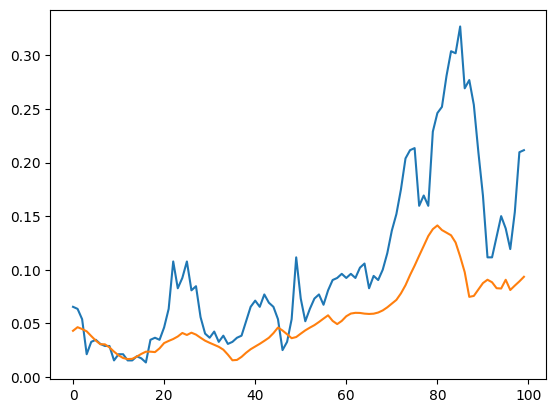

In [35]:
plt.plot(test_y[:])
plt.plot(testPredict[:])
plt.show()

In [43]:
n = 1 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])


X= np.array(X)
Y= np.array(Y)  
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

model = Sequential()
model.add(LSTM(32, input_shape=(1 * 24, 10), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(train_x,train_y, batch_size=128,epochs=100, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])
model.save("pm2.5_LSTM_1")

Epoch 1/100
247/247 [==============================] - 11s 26ms/step - loss: 0.0520 - val_loss: 0.0502 - lr: 0.0010
Epoch 2/100
247/247 [==============================] - 5s 21ms/step - loss: 0.0471 - val_loss: 0.0475 - lr: 0.0010
Epoch 3/100
247/247 [==============================] - 5s 19ms/step - loss: 0.0450 - val_loss: 0.0478 - lr: 0.0010
Epoch 4/100
247/247 [==============================] - 5s 20ms/step - loss: 0.0439 - val_loss: 0.0452 - lr: 0.0010
Epoch 5/100
247/247 [==============================] - 5s 22ms/step - loss: 0.0433 - val_loss: 0.0442 - lr: 0.0010
Epoch 6/100
247/247 [==============================] - 5s 21ms/step - loss: 0.0422 - val_loss: 0.0452 - lr: 0.0010
Epoch 7/100
247/247 [==============================] - 5s 20ms/step - loss: 0.0415 - val_loss: 0.0459 - lr: 0.0010
Epoch 8/100
247/247 [==============================] - 5s 20ms/step - loss: 0.0410 - val_loss: 0.0439 - lr: 0.0010
Epoch 9/100
247/247 [==============================] - 5s 20ms/step - loss: 0.0

INFO:tensorflow:Assets written to: pm2.5_LSTM_1\assets


In [44]:
n = 2 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])


X= np.array(X)
Y= np.array(Y)  
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

model = Sequential()
model.add(LSTM(32, input_shape=(2 * 24, 10), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(train_x,train_y, batch_size=128,epochs=100, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])
model.save("pm2.5_LSTM_2")

Epoch 1/100
247/247 [==============================] - 10s 30ms/step - loss: 0.0513 - val_loss: 0.0498 - lr: 0.0010
Epoch 2/100
247/247 [==============================] - 7s 27ms/step - loss: 0.0457 - val_loss: 0.0511 - lr: 0.0010
Epoch 3/100
247/247 [==============================] - 7s 27ms/step - loss: 0.0441 - val_loss: 0.0463 - lr: 0.0010
Epoch 4/100
247/247 [==============================] - 7s 26ms/step - loss: 0.0428 - val_loss: 0.0433 - lr: 0.0010
Epoch 5/100
247/247 [==============================] - 7s 26ms/step - loss: 0.0416 - val_loss: 0.0471 - lr: 0.0010
Epoch 6/100
247/247 [==============================] - 7s 26ms/step - loss: 0.0406 - val_loss: 0.0458 - lr: 0.0010
Epoch 7/100
247/247 [==============================] - 6s 26ms/step - loss: 0.0398 - val_loss: 0.0432 - lr: 0.0010
Epoch 8/100
247/247 [==============================] - 6s 26ms/step - loss: 0.0385 - val_loss: 0.0426 - lr: 5.0000e-04
Epoch 9/100
247/247 [==============================] - 7s 29ms/step - loss:

INFO:tensorflow:Assets written to: pm2.5_LSTM_2\assets


In [45]:
n = 3 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])


X= np.array(X)
Y= np.array(Y)  
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

model = Sequential()
model.add(LSTM(32, input_shape=(3 * 24, 10), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(train_x,train_y, batch_size=128,epochs=100, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])
model.save("pm2.5_LSTM_3")

Epoch 1/100
247/247 [==============================] - 14s 46ms/step - loss: 0.0511 - val_loss: 0.0509 - lr: 0.0010
Epoch 2/100
247/247 [==============================] - 10s 42ms/step - loss: 0.0451 - val_loss: 0.0476 - lr: 0.0010
Epoch 3/100
247/247 [==============================] - 10s 42ms/step - loss: 0.0434 - val_loss: 0.0482 - lr: 0.0010
Epoch 4/100
247/247 [==============================] - 10s 42ms/step - loss: 0.0425 - val_loss: 0.0468 - lr: 0.0010
Epoch 5/100
247/247 [==============================] - 11s 43ms/step - loss: 0.0417 - val_loss: 0.0448 - lr: 0.0010
Epoch 6/100
247/247 [==============================] - 11s 43ms/step - loss: 0.0401 - val_loss: 0.0425 - lr: 0.0010
Epoch 7/100
247/247 [==============================] - 11s 43ms/step - loss: 0.0391 - val_loss: 0.0407 - lr: 0.0010
Epoch 8/100
247/247 [==============================] - 11s 43ms/step - loss: 0.0387 - val_loss: 0.0410 - lr: 0.0010
Epoch 9/100
247/247 [==============================] - 10s 42ms/step - l

INFO:tensorflow:Assets written to: pm2.5_LSTM_3\assets


In [46]:
n = 4 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])


X= np.array(X)
Y= np.array(Y)  
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

model = Sequential()
model.add(LSTM(32, input_shape=(4 * 24, 10), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(train_x,train_y, batch_size=128,epochs=100, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])
model.save("pm2.5_LSTM_4")

Epoch 1/100
247/247 [==============================] - 19s 65ms/step - loss: 0.0506 - val_loss: 0.0463 - lr: 0.0010
Epoch 2/100
247/247 [==============================] - 15s 62ms/step - loss: 0.0453 - val_loss: 0.0428 - lr: 0.0010
Epoch 3/100
247/247 [==============================] - 15s 62ms/step - loss: 0.0430 - val_loss: 0.0436 - lr: 0.0010
Epoch 4/100
247/247 [==============================] - 15s 61ms/step - loss: 0.0416 - val_loss: 0.0433 - lr: 0.0010
Epoch 5/100
247/247 [==============================] - 15s 62ms/step - loss: 0.0406 - val_loss: 0.0393 - lr: 0.0010
Epoch 6/100
247/247 [==============================] - 15s 62ms/step - loss: 0.0395 - val_loss: 0.0452 - lr: 0.0010
Epoch 7/100
247/247 [==============================] - 16s 63ms/step - loss: 0.0384 - val_loss: 0.0425 - lr: 0.0010
Epoch 8/100
247/247 [==============================] - 15s 61ms/step - loss: 0.0382 - val_loss: 0.0430 - lr: 0.0010
Epoch 9/100
247/247 [==============================] - 15s 61ms/step - l

INFO:tensorflow:Assets written to: pm2.5_LSTM_4\assets


In [47]:
n = 5 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])


X= np.array(X)
Y= np.array(Y)  
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

model = Sequential()
model.add(LSTM(32, input_shape=(5 * 24, 10), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(train_x,train_y, batch_size=128,epochs=100, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])
model.save("pm2.5_LSTM_5")

Epoch 1/100
246/246 [==============================] - 23s 81ms/step - loss: 0.0495 - val_loss: 0.0454 - lr: 0.0010
Epoch 2/100
246/246 [==============================] - 19s 78ms/step - loss: 0.0451 - val_loss: 0.0438 - lr: 0.0010
Epoch 3/100
246/246 [==============================] - 19s 78ms/step - loss: 0.0427 - val_loss: 0.0432 - lr: 0.0010
Epoch 4/100
246/246 [==============================] - 19s 78ms/step - loss: 0.0417 - val_loss: 0.0441 - lr: 0.0010
Epoch 5/100
246/246 [==============================] - 19s 78ms/step - loss: 0.0408 - val_loss: 0.0453 - lr: 0.0010
Epoch 6/100
246/246 [==============================] - 19s 78ms/step - loss: 0.0397 - val_loss: 0.0428 - lr: 0.0010
Epoch 7/100
246/246 [==============================] - 19s 78ms/step - loss: 0.0392 - val_loss: 0.0426 - lr: 0.0010
Epoch 8/100
246/246 [==============================] - 19s 78ms/step - loss: 0.0380 - val_loss: 0.0416 - lr: 0.0010
Epoch 9/100
246/246 [==============================] - 19s 78ms/step - l

INFO:tensorflow:Assets written to: pm2.5_LSTM_5\assets


In [48]:
n = 6 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])


X= np.array(X)
Y= np.array(Y)  
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

model = Sequential()
model.add(LSTM(32, input_shape=(6 * 24, 10), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(train_x,train_y, batch_size=128,epochs=100, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])
model.save("pm2.5_LSTM_6")

Epoch 1/100
246/246 [==============================] - 24s 84ms/step - loss: 0.0526 - val_loss: 0.0454 - lr: 0.0010
Epoch 2/100
246/246 [==============================] - 20s 81ms/step - loss: 0.0453 - val_loss: 0.0425 - lr: 0.0010
Epoch 3/100
246/246 [==============================] - 20s 82ms/step - loss: 0.0432 - val_loss: 0.0432 - lr: 0.0010
Epoch 4/100
246/246 [==============================] - 20s 82ms/step - loss: 0.0421 - val_loss: 0.0434 - lr: 0.0010
Epoch 5/100
246/246 [==============================] - 20s 82ms/step - loss: 0.0406 - val_loss: 0.0439 - lr: 0.0010
Epoch 6/100
246/246 [==============================] - 20s 82ms/step - loss: 0.0386 - val_loss: 0.0423 - lr: 5.0000e-04
Epoch 7/100
246/246 [==============================] - 20s 82ms/step - loss: 0.0378 - val_loss: 0.0412 - lr: 5.0000e-04
Epoch 8/100
246/246 [==============================] - 20s 82ms/step - loss: 0.0370 - val_loss: 0.0400 - lr: 5.0000e-04
Epoch 9/100
246/246 [==============================] - 22s 8

INFO:tensorflow:Assets written to: pm2.5_LSTM_6\assets


In [50]:
n = 6 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])


X= np.array(X)
Y= np.array(Y)  
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

model = Sequential()
model.add(LSTM(32, input_shape=(6 * 24, 10), return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(train_x,train_y, batch_size=128,epochs=100, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])
model.save("pm2.5_LSTM_6.1")

Epoch 1/100
246/246 [==============================] - 17s 62ms/step - loss: 0.0559 - val_loss: 0.0485 - lr: 0.0010
Epoch 2/100
246/246 [==============================] - 13s 54ms/step - loss: 0.0468 - val_loss: 0.0457 - lr: 0.0010
Epoch 3/100
246/246 [==============================] - 13s 54ms/step - loss: 0.0442 - val_loss: 0.0429 - lr: 0.0010
Epoch 4/100
246/246 [==============================] - 13s 54ms/step - loss: 0.0426 - val_loss: 0.0430 - lr: 0.0010
Epoch 5/100
246/246 [==============================] - 13s 54ms/step - loss: 0.0414 - val_loss: 0.0445 - lr: 0.0010
Epoch 6/100
246/246 [==============================] - 13s 55ms/step - loss: 0.0407 - val_loss: 0.0415 - lr: 0.0010
Epoch 7/100
246/246 [==============================] - 13s 54ms/step - loss: 0.0398 - val_loss: 0.0448 - lr: 0.0010
Epoch 8/100
246/246 [==============================] - 13s 54ms/step - loss: 0.0394 - val_loss: 0.0420 - lr: 0.0010
Epoch 9/100
246/246 [==============================] - 13s 54ms/step - l

INFO:tensorflow:Assets written to: pm2.5_LSTM_6.1\assets


In [5]:
n = 3 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])


X= np.array(X)
Y= np.array(Y)  
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

model = Sequential()
model.add(LSTM(32, input_shape=(3 * 24, 10), return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(train_x,train_y, batch_size=128,epochs=100, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])
model.save("pm2.5_LSTM_3.1")

Epoch 1/100
247/247 [==============================] - 10s 32ms/step - loss: 0.0493 - val_loss: 0.0499 - lr: 0.0010
Epoch 2/100
247/247 [==============================] - 7s 29ms/step - loss: 0.0447 - val_loss: 0.0449 - lr: 0.0010
Epoch 3/100
247/247 [==============================] - 7s 29ms/step - loss: 0.0426 - val_loss: 0.0426 - lr: 0.0010
Epoch 4/100
247/247 [==============================] - 7s 29ms/step - loss: 0.0417 - val_loss: 0.0440 - lr: 0.0010
Epoch 5/100
247/247 [==============================] - 7s 30ms/step - loss: 0.0410 - val_loss: 0.0407 - lr: 0.0010
Epoch 6/100
247/247 [==============================] - 7s 30ms/step - loss: 0.0402 - val_loss: 0.0447 - lr: 0.0010
Epoch 7/100
247/247 [==============================] - 7s 30ms/step - loss: 0.0395 - val_loss: 0.0419 - lr: 0.0010
Epoch 8/100
247/247 [==============================] - 7s 30ms/step - loss: 0.0391 - val_loss: 0.0419 - lr: 0.0010
Epoch 9/100
247/247 [==============================] - 7s 30ms/step - loss: 0.0

INFO:tensorflow:Assets written to: pm2.5_LSTM_3.1\assets


In [51]:
n = 6 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])


X= np.array(X)
Y= np.array(Y)  
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

model = Sequential()
model.add(LSTM(32, input_shape=(6 * 24, 10), return_sequences=True))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(train_x,train_y, batch_size=128,epochs=100, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])
model.save("pm2.5_LSTM_6.2")

Epoch 1/100
246/246 [==============================] - 12s 44ms/step - loss: 0.0681 - val_loss: 0.0678 - lr: 0.0010
Epoch 2/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0662 - val_loss: 0.0663 - lr: 0.0010
Epoch 3/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0662 - val_loss: 0.0666 - lr: 0.0010
Epoch 4/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0659 - val_loss: 0.0662 - lr: 0.0010
Epoch 5/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0660 - val_loss: 0.0664 - lr: 0.0010
Epoch 6/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0660 - val_loss: 0.0662 - lr: 0.0010
Epoch 7/100
246/246 [==============================] - 10s 43ms/step - loss: 0.0660 - val_loss: 0.0668 - lr: 0.0010
Epoch 8/100
246/246 [==============================] - 10s 42ms/step - loss: 0.0659 - val_loss: 0.0662 - lr: 5.0000e-04
Epoch 9/100
246/246 [==============================] - 10s 42ms/step

INFO:tensorflow:Assets written to: pm2.5_LSTM_6.2\assets


In [86]:
n = 6 * 24
features = list(norm_data.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data[features]

for i in range(len(norm_data) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data['pm2.5'].iloc[i+n])
    indexes.append(norm_data.index[i+n])


X= np.array(X)
Y= np.array(Y)  
split_boundary = int(len(X) * 0.8)
train_x = X[: split_boundary]
test_x = X[split_boundary:]

train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

model = Sequential()
model.add(LSTM(50, input_shape=(6 * 24, 10), return_sequences=True))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(train_x,train_y, batch_size=72,epochs=100, validation_data=(test_x,test_y), callbacks=[learning_rate_reduction])
model.save("pm2.5_LSTM_6.3")

Epoch 1/100
438/438 [==============================] - 34s 74ms/step - loss: 0.0677 - val_loss: 0.0662 - lr: 0.0010
Epoch 2/100
438/438 [==============================] - 34s 77ms/step - loss: 0.0661 - val_loss: 0.0661 - lr: 0.0010
Epoch 3/100
438/438 [==============================] - 45s 102ms/step - loss: 0.0660 - val_loss: 0.0663 - lr: 0.0010
Epoch 4/100
438/438 [==============================] - 22s 50ms/step - loss: 0.0660 - val_loss: 0.0669 - lr: 0.0010
Epoch 5/100
438/438 [==============================] - 21s 47ms/step - loss: 0.0658 - val_loss: 0.0662 - lr: 5.0000e-04
Epoch 6/100
438/438 [==============================] - 17s 39ms/step - loss: 0.0659 - val_loss: 0.0665 - lr: 5.0000e-04
Epoch 7/100
438/438 [==============================] - 17s 39ms/step - loss: 0.0658 - val_loss: 0.0661 - lr: 5.0000e-04
Epoch 8/100
438/438 [==============================] - 17s 39ms/step - loss: 0.0657 - val_loss: 0.0665 - lr: 2.5000e-04
Epoch 9/100
438/438 [==============================] - 

INFO:tensorflow:Assets written to: pm2.5_LSTM_6.3\assets


134/134 [==============================] - 2s 5ms/step
Test Score: 0.1395 RMSE
Test Score: 0.0195 MSE


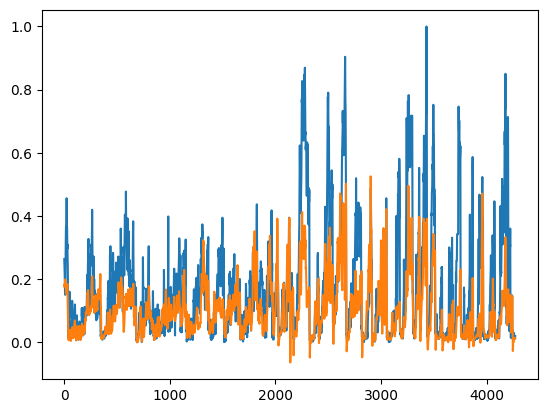

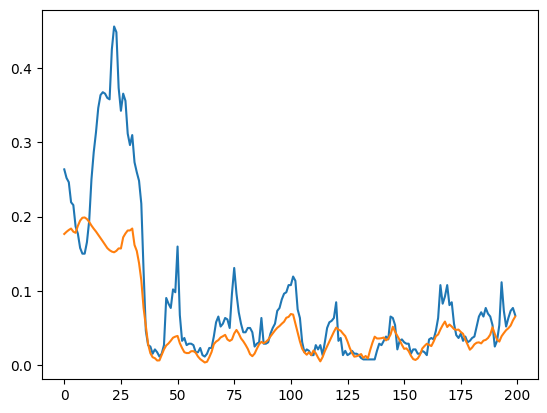

In [75]:
n = 1 * 24
features = list(norm_data_test.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data_test[features]

for i in range(len(norm_data_test) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data_test['pm2.5'].iloc[i+n])
    indexes.append(norm_data_test.index[i+n])

X= np.array(X)
Y= np.array(Y)
test_x = X[:]
test_y = Y[:]

model_1 = tf.keras.models.load_model('./pm2.5_LSTM_1')
testPredict = model_1.predict(test_x)

testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
testScore = (mean_squared_error(test_y, testPredict))
print('Test Score: %.4f MSE' % (testScore))

plt.plot(test_y[:])
plt.plot(testPredict[:])
plt.show()

plt.plot(test_y[:200])
plt.plot(testPredict[:200])
plt.show()



133/133 [==============================] - 2s 10ms/step
Test Score: 0.1430 RMSE
Test Score: 0.0205 MSE


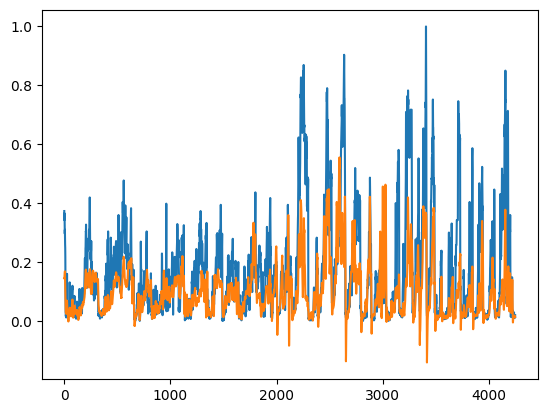

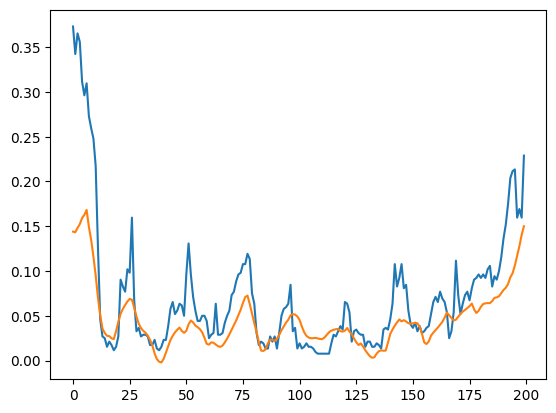

In [74]:
n = 2 * 24
features = list(norm_data_test.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data_test[features]

for i in range(len(norm_data_test) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data_test['pm2.5'].iloc[i+n])
    indexes.append(norm_data_test.index[i+n])

X= np.array(X)
Y= np.array(Y)
test_x = X[:]
test_y = Y[:]

model_2 = tf.keras.models.load_model('./pm2.5_LSTM_2')
testPredict = model_2.predict(test_x)

testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
testScore = (mean_squared_error(test_y, testPredict))
print('Test Score: %.4f MSE' % (testScore))

plt.plot(test_y[:])
plt.plot(testPredict[:])
plt.show()

plt.plot(test_y[:200])
plt.plot(testPredict[:200])
plt.show()

132/132 [==============================] - 3s 16ms/step
Test Score: 0.1381 RMSE
Test Score: 0.0191 MSE


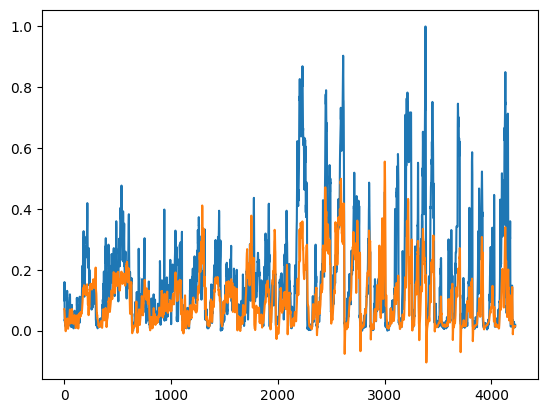

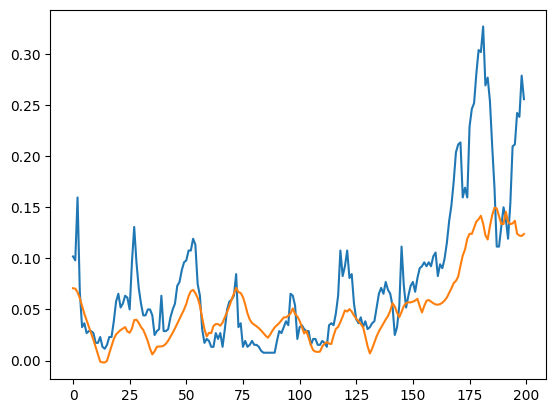

In [73]:
n = 3 * 24
features = list(norm_data_test.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data_test[features]

for i in range(len(norm_data_test) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data_test['pm2.5'].iloc[i+n])
    indexes.append(norm_data_test.index[i+n])

X= np.array(X)
Y= np.array(Y)
test_x = X[:]
test_y = Y[:]

model_3 = tf.keras.models.load_model('./pm2.5_LSTM_3')
testPredict = model_3.predict(test_x)

testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
testScore = (mean_squared_error(test_y, testPredict))
print('Test Score: %.4f MSE' % (testScore))

plt.plot(test_y[:])
plt.plot(testPredict[:])
plt.show()

plt.plot(test_y[:200])
plt.plot(testPredict[:200])
plt.show()

132/132 [==============================] - 4s 23ms/step
Test Score: 0.1414 RMSE
Test Score: 0.0200 MSE


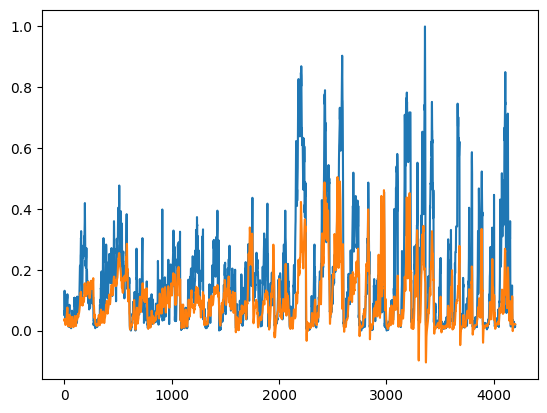

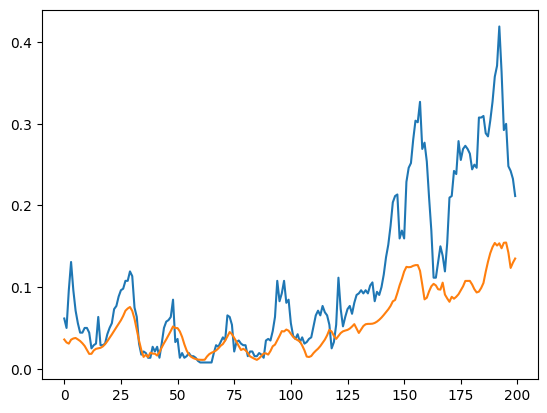

In [72]:
n = 4 * 24
features = list(norm_data_test.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data_test[features]

for i in range(len(norm_data_test) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data_test['pm2.5'].iloc[i+n])
    indexes.append(norm_data_test.index[i+n])

X= np.array(X)
Y= np.array(Y)
test_x = X[:]
test_y = Y[:]

model_4 = tf.keras.models.load_model('./pm2.5_LSTM_4')
testPredict = model_4.predict(test_x)

testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
testScore = (mean_squared_error(test_y, testPredict))
print('Test Score: %.4f MSE' % (testScore))

plt.plot(test_y[:])
plt.plot(testPredict[:])
plt.show()

plt.plot(test_y[:200])
plt.plot(testPredict[:200])
plt.show()

131/131 [==============================] - 4s 27ms/step
Test Score: 0.1424 RMSE
Test Score: 0.0203 MSE


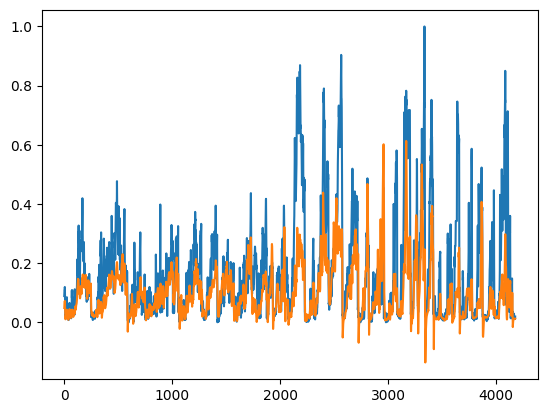

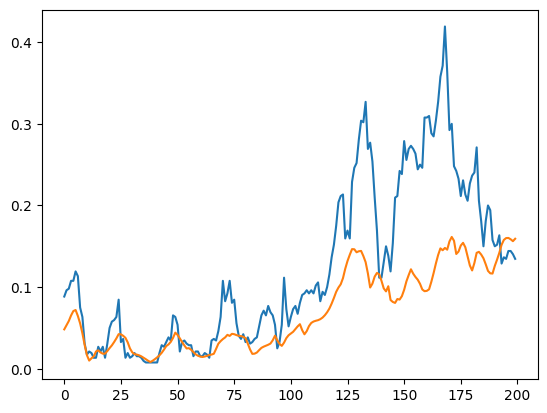

In [71]:
n = 5 * 24
features = list(norm_data_test.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data_test[features]

for i in range(len(norm_data_test) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data_test['pm2.5'].iloc[i+n])
    indexes.append(norm_data_test.index[i+n])

X= np.array(X)
Y= np.array(Y)
test_x = X[:]
test_y = Y[:]

model_5 = tf.keras.models.load_model('./pm2.5_LSTM_5')
testPredict = model_5.predict(test_x)

testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
testScore = (mean_squared_error(test_y, testPredict))
print('Test Score: %.4f MSE' % (testScore))

plt.plot(test_y[:])
plt.plot(testPredict[:])
plt.show()

plt.plot(test_y[:200])
plt.plot(testPredict[:200])
plt.show()

130/130 [==============================] - 5s 34ms/step
Test Score: 0.1445 RMSE
Test Score: 0.0209 MSE


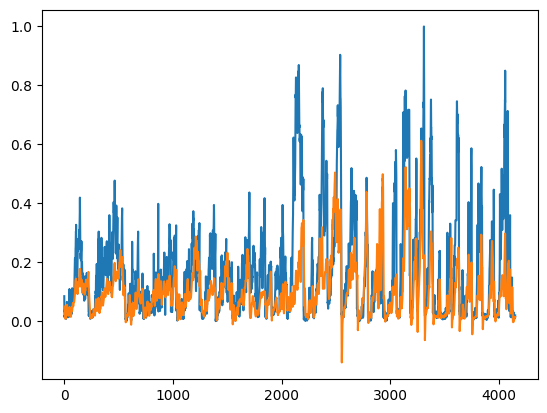

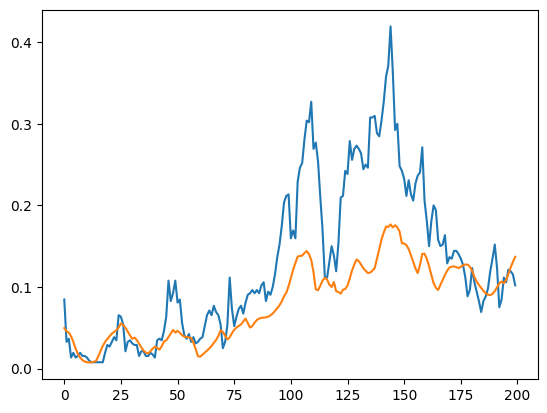

In [70]:
n = 6 * 24
features = list(norm_data_test.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data_test[features]

for i in range(len(norm_data_test) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data_test['pm2.5'].iloc[i+n])
    indexes.append(norm_data_test.index[i+n])

X= np.array(X)
Y= np.array(Y)
test_x = X[:]
test_y = Y[:]

model_6 = tf.keras.models.load_model('./pm2.5_LSTM_6')
testPredict = model_6.predict(test_x)

testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
testScore = (mean_squared_error(test_y, testPredict))
print('Test Score: %.4f MSE' % (testScore))

plt.plot(test_y[:])
plt.plot(testPredict[:])
plt.show()

plt.plot(test_y[:200])
plt.plot(testPredict[:200])
plt.show()

130/130 [==============================] - 3s 18ms/step
Test Score: 0.1373 RMSE
Test Score: 0.0189 MSE


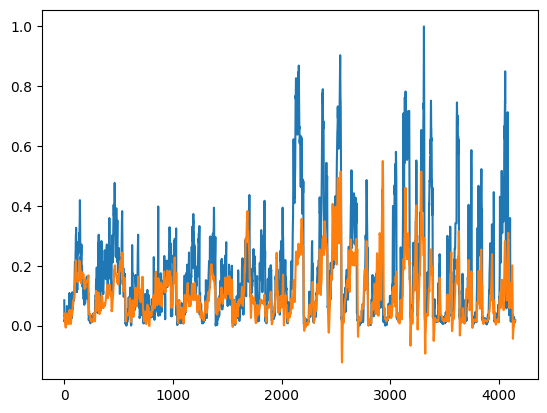

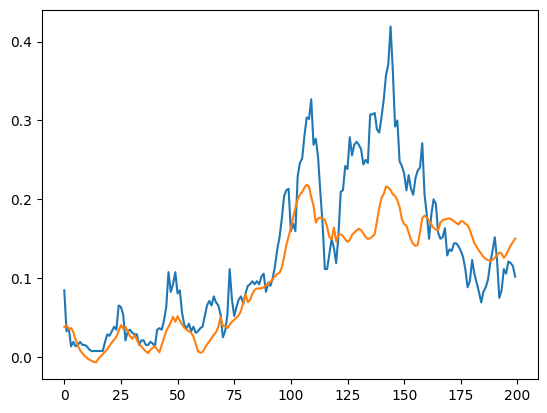

In [69]:
n = 6 * 24
features = list(norm_data_test.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data_test[features]

for i in range(len(norm_data_test) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data_test['pm2.5'].iloc[i+n])
    indexes.append(norm_data_test.index[i+n])

X= np.array(X)
Y= np.array(Y)
test_x = X[:]
test_y = Y[:]

model_6 = tf.keras.models.load_model('./pm2.5_LSTM_6.1')
testPredict = model_6.predict(test_x)

testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
testScore = (mean_squared_error(test_y, testPredict))
print('Test Score: %.4f MSE' % (testScore))

plt.plot(test_y[:])
plt.plot(testPredict[:])
plt.show()

plt.plot(test_y[:200])
plt.plot(testPredict[:200])
plt.show()

129/129 [==============================] - 4s 25ms/step
Test Score: 0.1427 RMSE
Test Score: 0.0204 MSE


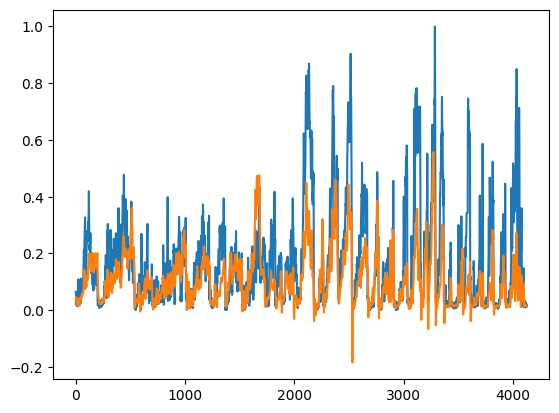

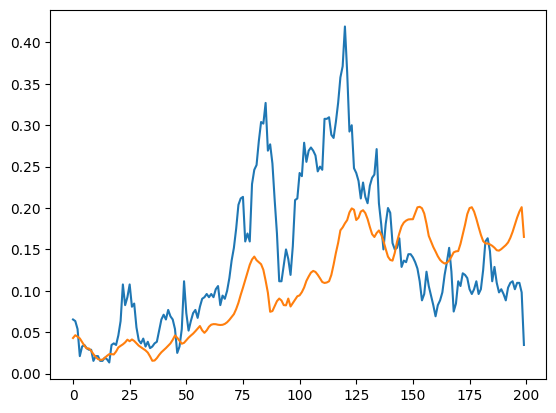

In [87]:
n = 7 * 24
features = list(norm_data_test.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data_test[features]

for i in range(len(norm_data_test) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data_test['pm2.5'].iloc[i+n])
    indexes.append(norm_data_test.index[i+n])

X= np.array(X)
Y= np.array(Y)
test_x = X[:]
test_y = Y[:]

model_7 = tf.keras.models.load_model('./pm2.5_LSTM_7')
testPredict = model_7.predict(test_x)

testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
testScore = (mean_squared_error(test_y, testPredict))
print('Test Score: %.4f MSE' % (testScore))

plt.plot(test_y[:])
plt.plot(testPredict[:])
plt.show()

plt.plot(test_y[:200])
plt.plot(testPredict[:200])
plt.show()

132/132 [==============================] - 1s 7ms/step
Test Score: 0.1328 RMSE
Test Score: 0.0176 MSE


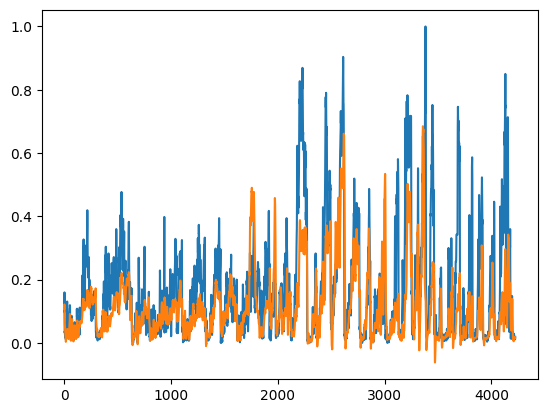

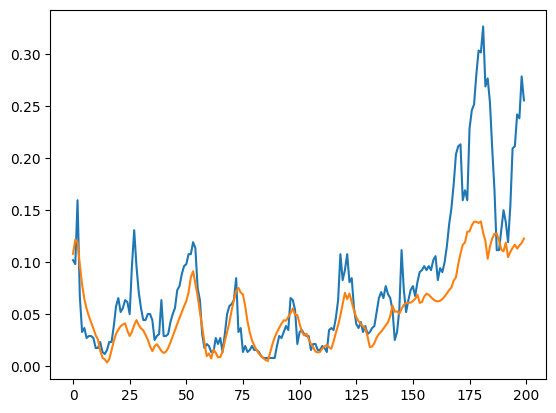

In [9]:
n = 3 * 24
features = list(norm_data_test.drop('pm2.5',axis=1).columns)
X = []
Y = []
indexes = []
norm_data_X = norm_data_test[features]

for i in range(len(norm_data_test) - n):
    X.append(norm_data_X.iloc[i:i+n].values)
    Y.append(norm_data_test['pm2.5'].iloc[i+n])
    indexes.append(norm_data_test.index[i+n])

X= np.array(X)
Y= np.array(Y)
test_x = X[:]
test_y = Y[:]

model_3_1 = tf.keras.models.load_model('./pm2.5_LSTM_3.1')
testPredict = model_3_1.predict(test_x)

testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
testScore = (mean_squared_error(test_y, testPredict))
print('Test Score: %.4f MSE' % (testScore))

plt.plot(test_y[:])
plt.plot(testPredict[:])
plt.show()

plt.plot(test_y[:200])
plt.plot(testPredict[:200])
plt.show()